# Import Necessary Libraries & Set up GPU

In [2]:
# Import Necessary Libraries
import torch
import torch.nn as nn

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

try:
  from torchinfo import summary
except:
  print(f"Installing torchinfo ...")
  !pip install torchinfo
  from torchinfo import summary

# Imoprt modular_pytorch library from personal GitHub repo
try:
  import modular_pytorch
except:
  print(f"Cloning 'Modular Pytorch' folder from GitHub")
  !git clone https://github.com/axeleichelmann/learn_pytorch_course
  !mv learn_pytorch_course/modular_pytorch .
  !rm -rf learn_pytorch_course
  from modular_pytorch import data_setup, engine

Installing torchinfo ...
Cloning 'Modular Pytorch' folder from GitHub
Cloning into 'learn_pytorch_course'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 3.25 MiB | 11.75 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [3]:
# Setup device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import Image Data & Create Dataloaders

In [4]:
# Import Pizza, Sushi & Steak data from Daniel Bourke's GitHub
from pathlib import Path
import zipfile
import os
import requests

github_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_path = Path("data")
img_path = data_path / "pizza_steak_sushi"

# Create data directory
if data_path.is_dir():
  print(f"Directory {data_path} already exists.")
else:
  print(f"Creating directory {data_path} ...")
  data_path.mkdir(parents=True, exist_ok=True)

# Import data zipfile from GitHub
with open(data_path / "pizza_sushi_steak.zip", "wb") as f:
  request = requests.get(github_url)
  print(f"Importing data zip file from GitHub...")
  f.write(request.content)

# Open contents of zipfile into `img_path` directory
with zipfile.ZipFile(data_path / "pizza_sushi_steak.zip", "r") as zipref:
  print(f"Unzipping image data zipfile")
  zipref.extractall(img_path)

# Remove zipfile from data directory
os.remove(data_path / "pizza_sushi_steak.zip")


Creating directory data ...
Importing data zip file from GitHub...
Unzipping image data zipfile


In [5]:
# Create training & testing dataloaders using functions from data_setup.py
from modular_pytorch import data_setup

# Define training & testing directories
train_dir = img_path / "train"
test_dir = img_path / "test"

# Define transformations to apply on training & testing data - NOTE: Images must be resized to at least 224x224 in order to work with the pretrained models that we will be using
std_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # Normalize data by the mean and std. dev's of the ImageNet training dataset
])

# Alternative way of getting the correct transforms to apply to the data
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transform = weights.transforms()

# Create dataloaders
BATCH_SIZE = 8
NUM_WORKERS = 0

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir,
                                                                               train_transform=std_transform, test_transform=std_transform,
                                                                               batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Create & Train Model

In [23]:
# Importing the pretrained efficientnet_b0 model
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# Freeze the parameters in the 'features' layer
for param in model.features.parameters():
  param.requires_grad = False

# Set the output shape to 3
output_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=output_shape)
).to(device)

In [24]:
# Print summary of the model
summary(model=model,
        input_size=(8,3,224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [8, 3, 224, 224]     [8, 3]               --                   Partial
├─Sequential (features)                                      [8, 3, 224, 224]     [8, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [8, 3, 224, 224]     [8, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [8, 3, 224, 224]     [8, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [8, 32, 112, 112]    [8, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [8, 32, 112, 112]    [8, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [8, 32, 112, 112]    [8, 1

In [25]:
# Carry out model training & evaluation using engine.py
from modular_pytorch import engine

# Define parameter value for 'train_model' function
NUM_EPOCHS = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001)

# Carry out model training
train_loss, train_acc, test_loss, test_acc = engine.train_model(model=model, num_epochs= NUM_EPOCHS,
                                                                train_dataloader = train_dataloader, test_dataloader = test_dataloader,
                                                                optimizer = optimizer, device = device, loss_fn = loss_fn)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 0 | Train Loss = 1.0943, Train Acc = 0.387931 | Test Loss = 1.0597, Test Acc = 0.48
Epoch : 10 | Train Loss = 0.8708, Train Acc = 0.754310 | Test Loss = 0.8584, Test Acc = 0.70
Epoch : 20 | Train Loss = 0.7353, Train Acc = 0.818966 | Test Loss = 0.7375, Test Acc = 0.82
Epoch : 30 | Train Loss = 0.6438, Train Acc = 0.875000 | Test Loss = 0.6368, Test Acc = 0.88
Epoch : 40 | Train Loss = 0.6305, Train Acc = 0.801724 | Test Loss = 0.5793, Test Acc = 0.91
Epoch : 50 | Train Loss = 0.5455, Train Acc = 0.900862 | Test Loss = 0.5270, Test Acc = 0.89
Epoch : 60 | Train Loss = 0.5501, Train Acc = 0.818966 | Test Loss = 0.5157, Test Acc = 0.89
Epoch : 70 | Train Loss = 0.4886, Train Acc = 0.900862 | Test Loss = 0.4710, Test Acc = 0.91
Epoch : 80 | Train Loss = 0.4843, Train Acc = 0.827586 | Test Loss = 0.4723, Test Acc = 0.91
Epoch : 90 | Train Loss = 0.4603, Train Acc = 0.853448 | Test Loss = 0.4254, Test Acc = 0.93


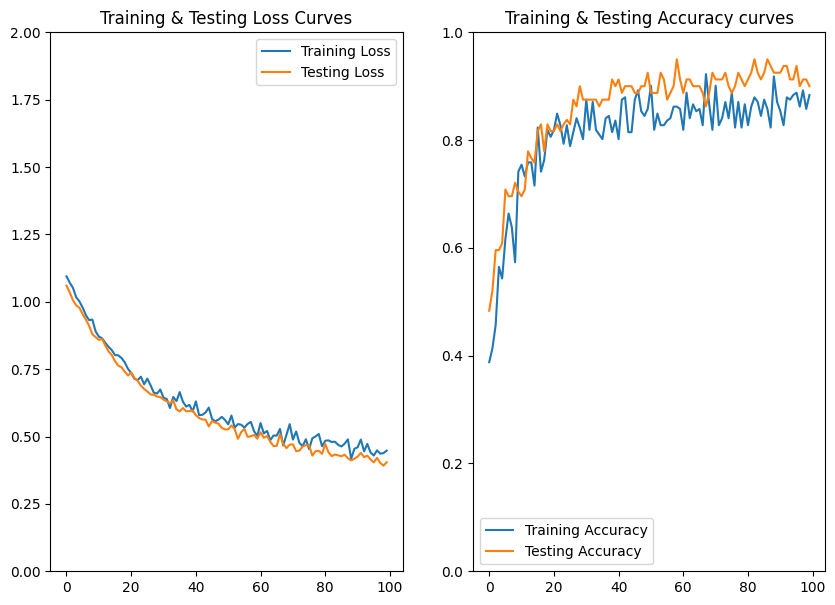

In [26]:
# Plot Loss Curves to Evaluate Model training results
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.plot(torch.stack(train_loss).detach().cpu(), label="Training Loss")
plt.plot(test_loss, label="Testing Loss")
plt.ylim(0,2)
plt.title("Training & Testing Loss Curves")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(test_acc, label="Testing Accuracy")
plt.title("Training & Testing Accuracy curves")
plt.ylim(0,1)
plt.legend()

plt.show()

# Make Predictions on Images from the Test Dataset

In [27]:
# Create function to plot and predict class of testing images
import PIL

def plot_and_pred(img_file_path : str,
                  model : nn.Module, class_names,
                  transform : transforms.Compose, device : torch.device):

  # Open PIL image
  pil_img = PIL.Image.open(img_file_path)

  # Predict class of image
  img_tensor = transform(pil_img)
  model.eval()
  with torch.inference_mode():
    pred_prob = model(img_tensor.unsqueeze(0)).softmax(dim=1)
    pred_class = pred_prob.argmax(dim=1)

  # Plot PIL Image and its predicted class
  plt.imshow(pil_img)
  plt.title(f"Predicted Class = {class_names[pred_class]}, Prediction Probability = {pred_prob.max():.3f}")
  plt.axis(False)

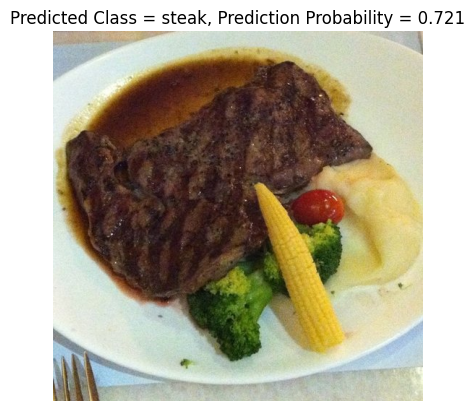

In [28]:
# Plot random images from testing dataset and their corresponding predicted label
import random

num_plots = 3
test_img_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_img_samples = random.sample(population=test_img_path_list,
                                k=num_plots)

for image_path in test_img_samples:
  plot_and_pred(image_path,
                model, class_names,
                std_transform, device)

# Make a Prediction on a Custom Image

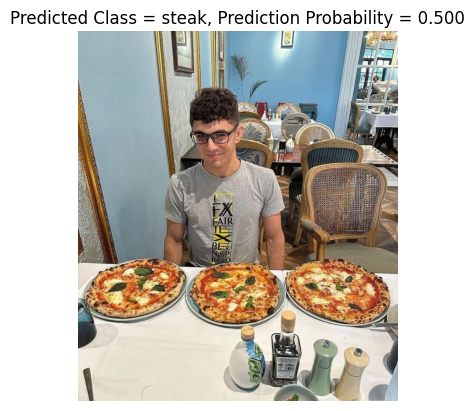

In [29]:
# Download custom image of pizza
github_url_custom_pic = "https://github.com/axeleichelmann/learn_pytorch_course/raw/main/data/mikey_muscemeci_pizza.jpg"
custom_img_path = data_path / "mikey_muscemeci_pizza.jpg"

with open(custom_img_path, "wb") as f:
  request = requests.get(github_url_custom_pic)
  print(f"Downloading jpg of Mikey Muscemeci eating pizza ...")
  f.write(request.content)

# Plot custom image and predict class
plot_and_pred(custom_img_path,
              model, class_names,
              std_transform, device)